**This script categorizes facial images from the CelebA dataset based on a combination of image processing techniques and enhanced heuristics. It then recommends outfits from the Fashion MNIST dataset based on the assigned categories, with the MNIST images further enhanced through contrast, noise reduction, and edge detection.**

**Methods Used**

Edge detection using Canny method for facial image categorization.

Contrast analysis using histogram equalization.

Brightness assessment using mean pixel intensity.

MNIST image enhancement through contrast adjustment, noise reduction, and edge detection.

Random selection for recommendations within the matching categories.

**Challenges**

The heuristic approach is effective but may not capture all nuances.
The Fashion MNIST dataset's limited diversity restricts the recommendations.

## Load the Dataset from Kaggle

In [1]:
# Download CelebA dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

# Download Fashion MNIST dataset
!kaggle datasets download -d zalando-research/fashionmnist

# Unzip the datasets
!unzip celeba-dataset.zip -d celeba
!unzip fashionmnist.zip -d fashion_mnist

Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197618.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197619.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197620.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197621.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197622.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197623.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197624.jpg  
  inflating

## Import Libraries

In [25]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import random
from skimage import feature, exposure, filters
from skimage.restoration import denoise_tv_chambolle
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

## Load CelebA Dataset and Display it

Total images in CelebA dataset: 202599
First 5 image filenames: ['015253.jpg', '015868.jpg', '150494.jpg', '029637.jpg', '060436.jpg']


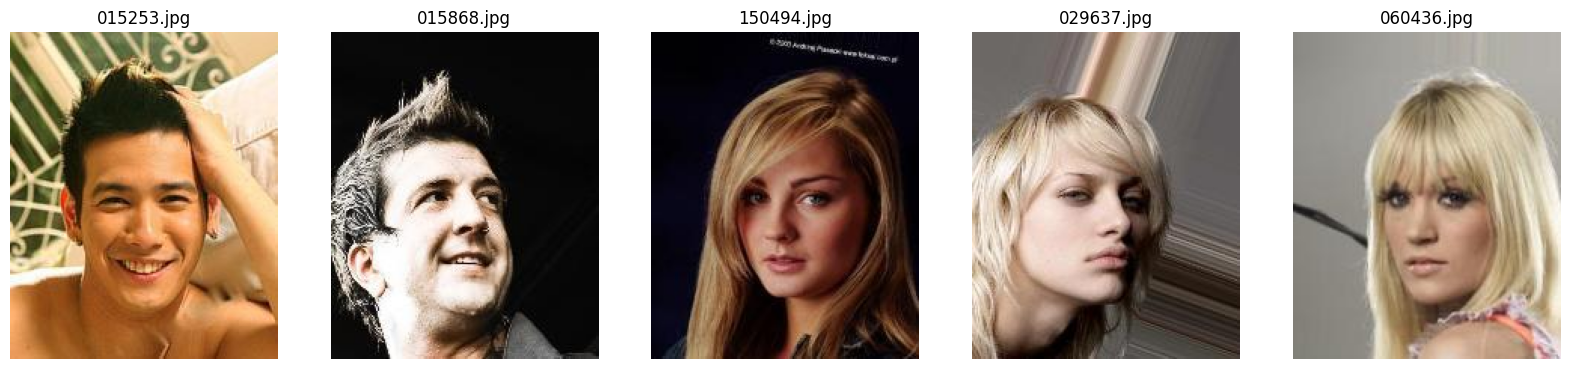

In [3]:
# Load image filenames
image_dir = '/content/celeba/img_align_celeba/img_align_celeba'
image_files = os.listdir(image_dir)

# Display the first few image filenames
print("Total images in CelebA dataset:", len(image_files))
print("First 5 image filenames:", image_files[:5])

# Display a few sample images
sample_images = image_files[:5]
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, img_file in enumerate(sample_images):
    img = Image.open(os.path.join(image_dir, img_file))
    axs[i].imshow(img)
    axs[i].set_title(img_file)
    axs[i].axis('off')
plt.show()

## Load Fashion_Mnist and Display it

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


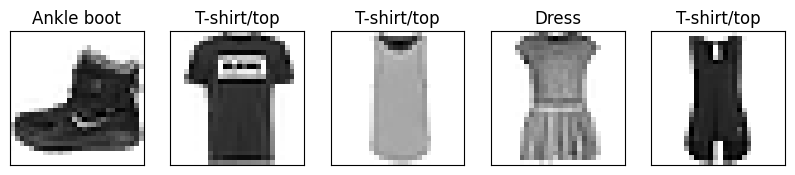

In [5]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Display the shape of the dataset
print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Define the class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot a few sample images from Fashion MNIST
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[i]])
plt.show()

# 1. Data Setup

In [28]:
# Load Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class names for Fashion MNIST
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Load a subset of CelebA dataset

In [ ]:

celeba_dir = '/content/celeba/img_align_celeba/img_align_celeba'  # Update this to the correct path
def load_and_preprocess_celeba_images(image_dir, image_size=(128, 128), limit=15):
    image_files = os.listdir(image_dir)[:limit]
    images = []
    for img_file in image_files:
        img = Image.open(os.path.join(image_dir, img_file)).resize(image_size)
        images.append(np.array(img))
    return np.array(images), image_files

celeba_images, celeba_filenames = load_and_preprocess_celeba_images(celeba_dir, limit=10)

# 2. Enhanced Heuristic-Based Categorization with Image Processing

In [29]:
def categorize_face(image):
    # Convert image to grayscale for edge detection and contrast analysis
    gray_image = image.mean(axis=2)  # Convert to grayscale

    # 1. Edge Detection: Use Canny edge detection
    edges = feature.canny(gray_image, sigma=2)
    edge_density = np.sum(edges) / edges.size

    # 2. Contrast Analysis: Use histogram equalization
    contrast = exposure.is_low_contrast(gray_image, fraction_threshold=0.35)

    # 3. Mean Pixel Intensity: Calculate the brightness
    mean_pixel_value = np.mean(image)

    # Categorization Logic:
    if edge_density > 0.15 and not contrast:
        return "Coat" if random.random() > 0.5 else "Dress"  # Detailed, sharp images likely to be formal
    elif mean_pixel_value > 130 or contrast:
        return "Pullover" if random.random() > 0.5 else "Shirt"  # Brighter or low-contrast images likely semi-formal
    else:
        return "T-shirt/top" if random.random() > 0.5 else "Sneaker"  # Darker images likely casual

# Categorize each CelebA image with the enhanced method
categories = [categorize_face(img) for img in celeba_images]

# 3. Outfit Recommendation

In [30]:
# Match each categorized CelebA image to a Fashion MNIST category
def recommend_outfit(category):
    category_index = class_names.index(category)
    matching_images = test_images[test_labels == category_index]
    return random.choice(matching_images)

# Enhance Fashion MNIST images
def enhance_mnist_image(image):
    # 1. Contrast Enhancement using Histogram Equalization
    image = exposure.equalize_hist(image)

    # 2. Noise Reduction using Total Variation Denoising
    image = denoise_tv_chambolle(image, weight=0.1)

    # 3. Edge Enhancement using Sobel Filter
    edges = filters.sobel(image)

    # Combine original and edges for enhanced effect
    enhanced_image = np.clip(image + edges, 0, 1)

    return enhanced_image

# Generate recommendations with enhanced MNIST images
recommendations = [(filename, category, enhance_mnist_image(recommend_outfit(category)))
                   for filename, category in zip(celeba_filenames, categories)]

# 4. High-Quality Visualization with Matplotlib

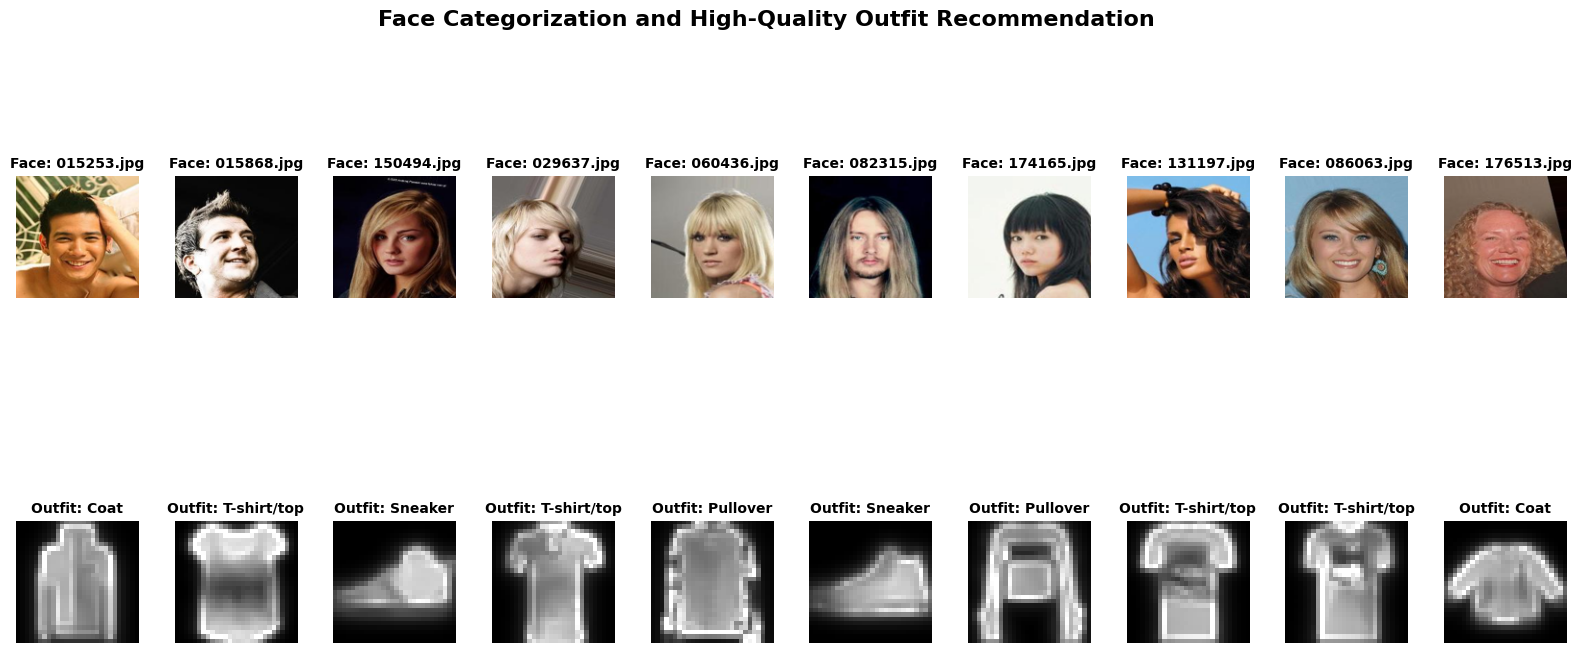

In [31]:
# Display the results in an innovative format
fig, axs = plt.subplots(2, len(recommendations), figsize=(20, 8))

for i, (filename, category, outfit) in enumerate(recommendations):
    # Plot the CelebA image
    axs[0, i].imshow(celeba_images[i])
    axs[0, i].set_title(f"Face: {filename}", fontsize=10, fontweight='bold')
    axs[0, i].axis('off')

    # Plot the recommended outfit in high-quality grayscale
    axs[1, i].imshow(outfit, cmap='gray')  # Grayscale colormap for original appearance
    axs[1, i].set_title(f"Outfit: {category}", fontsize=10, fontweight='bold')
    axs[1, i].axis('off')

# Overall title and layout adjustments
fig.suptitle("Face Categorization and High-Quality Outfit Recommendation", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)
plt.show()

# 5. Output the results to a file

In [32]:

output_file = "outfit_recommendations.txt"

with open(output_file, "w") as f:
    for filename, category, outfit in recommendations:
        f.write(f"Image: {filename}, Category: {category}, Recommended Outfit: {category}\n")

print(f"Recommendations saved to {output_file}")

Recommendations saved to outfit_recommendations.txt
